# Student's t distribution

For more information, see chapters 9 and 12

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import gamma, digamma
from scipy.stats import t, norm

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

apikey = os.environ["AVANTAGE_API"]

Student's t distribution is defined as an ensamble of normal distributions "weighted" by precision terms $\tau$ that are Gamma-distributed. That is

$$
\begin{aligned}
    p(x|\mu, \alpha, \beta) &= \int_0^\infty \mathcal{N}\left(x |\mu, \tau^{-1}\right)\text{Gam}(\tau|\alpha, \beta) \ d\tau \\
    &= \frac{\beta^\alpha}{\Gamma(\alpha)}\left(\frac{1}{2\pi}\right)^{1/2}\left[b + \frac{(x - \mu)^2}{2}\right]^{-a - 1/2} \Gamma\left(a + \frac{1}{2}\right)
\end{aligned}
$$

Defining $\nu = 2\alpha$, $\lambda = \alpha/\beta$ and rearranging, we obtain the final form of the distribution in the form

$$
    \text{St}(x\vert\mu,\lambda,\nu) = \frac{\Gamma\big((\nu + 1)/2\big)}{\Gamma(\nu/2)}\left(\frac{\lambda}{\pi\nu}\right)^{1/2}\left[1 + \frac{\lambda(x - \mu)^2}{\nu}\right]^{-(\nu + 1)/2}
$$

* $\nu$ is known as the degrees of freedom of the distribution;
* $\lambda$ is known as the precision of the distribution

In [3]:
def students(x, mu, lmbda, nu):
    """
    Generates a function that returns the value
    of the pdf of a Student's-t distribution
    
    Parameters
    ----------
    x: float, np.array
        Values to evaluate the pdf at
    mu: float
        The mean of the distribution
    lmbda: float
        The precision of the distribution
    nu: float
        The degrees of freedom of the distributino
    """
    const = gamma(nu / 2 + 1 / 2) / gamma(nu / 2) * np.sqrt(lmbda / (np.pi * nu))
    pdf = const * (1 + (lmbda * (x - mu) ** 2) / nu) ** (-nu / 2 - 1 / 2)
    return pdf

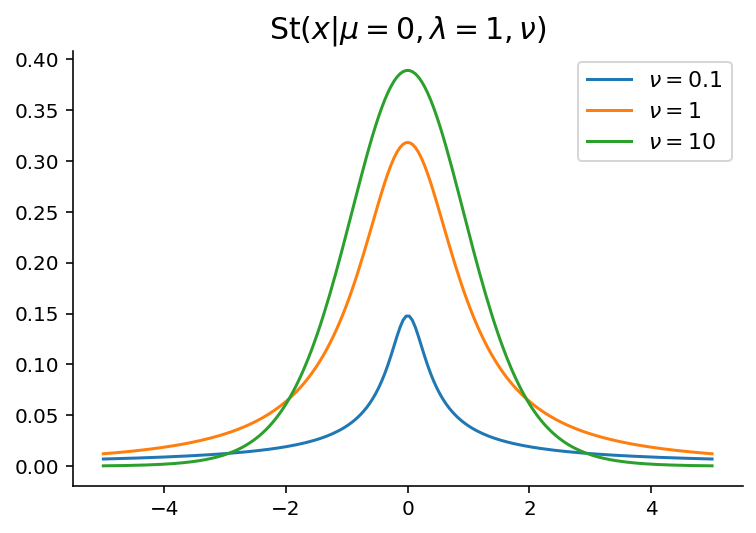

In [4]:
mu, lmbda= 0, 1

xrange = np.linspace(-5, 5, 200)

nus = [0.1, 1, 10]
for nu in nus:
    pdf = students(xrange, mu, lmbda, nu)
    plt.plot(xrange, pdf, label=rf"$\nu={nu}$");
plt.title(r"$\mathrm{St}"rf"(x\vert\mu={mu}, \lambda={lmbda}, \nu)$", fontsize=15)
plt.legend(fontsize=11);

## Estimating the parameters of a stock

In [5]:
# https://www.alphavantage.co/documentation/
url = "https://www.alphavantage.co/query"
symbol = "TSLA"
params = {
    "function": "TIME_SERIES_DAILY_ADJUSTED",
    "symbol": symbol,
    "outputsize": "full",
    "apikey": apikey
}

r = requests.get(url, params=params)
r

<Response [200]>

In [6]:
stock = pd.DataFrame.from_dict(r.json()["Time Series (Daily)"], orient="index", dtype=float)
stock.index = pd.to_datetime(stock.index)
stock = stock.sort_index()

In [7]:
stock_ret = stock.rename({"5. adjusted close": symbol}, axis=1)[symbol].pct_change().dropna()
N = len(stock_ret)
mu, sigma = stock_ret.mean(), stock_ret.std(ddof=1)
N_stock = norm(loc=mu, scale=sigma)

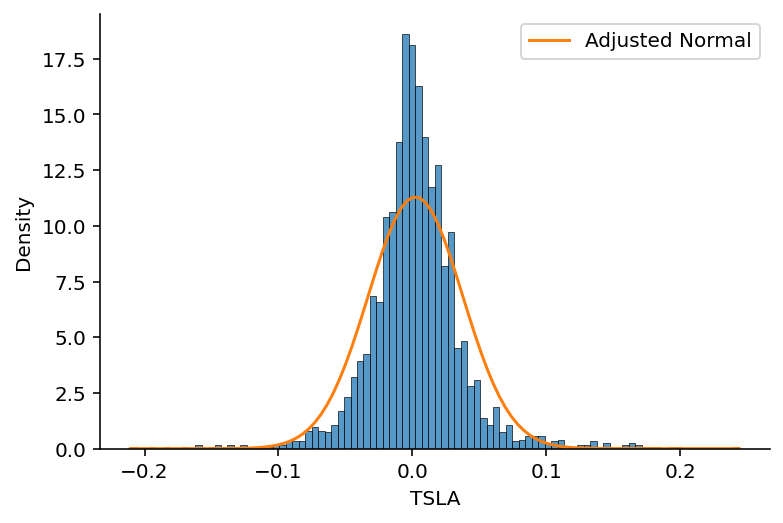

In [8]:
xrange = np.linspace(stock_ret.min(), stock_ret.max(), 100)
sns.histplot(stock_ret, kde=False, stat="density");
plt.plot(xrange, N_stock.pdf(xrange), label="Adjusted Normal", c="tab:orange")
plt.legend();

## Student's-t EM

In order to estimate the parameters of the Student's-t distribution, we make use of the EM algorithm which involves maximizing the expected complete-data log likelihood given by 

$$
\begin{aligned}
Q(\boldsymbol\theta, \boldsymbol\theta^{\text{old}}) &= -\frac{N}{2}\log 2\pi + \frac{1}{2}\sum_{n=1}^N\mathbb{E}[\log\eta_n] - \frac{N}{2}\log\lambda - \frac{\lambda}{2}\sum_{n=1}^N\mathbb{E}[\eta_n](x_n - \mu)^2 \\
&+ \frac{N\nu}{2}\log\frac{\nu}{2} - N\log\Gamma\left(\frac{\eta}{2}\right) + \left(\frac{\nu}{2} - 1\right)\sum_{n=1}^N\mathbb{E}[\log\eta_n] - \frac{\nu}{2}\mathbb{E}[\eta_n]
\end{aligned}
$$

----

In the **E** step of the algorithm, we compute the sufficient statistics

$$
    \mathbb{E}[\eta_n] = \frac{\nu + 1}{\nu + \lambda (x_n - \mu)^2}
$$

$$
    \mathbb{E}[\log\eta_n] = \psi\left(\frac{1}{2}(\eta + 1)\right) - \log\left(\frac{1}{2}[\eta + \lambda(x_n - \mu^2)]\right)
$$


--- 

For the **M** step we update $\mu$ amd $\lambda$ as

$$
\mu^\text{new} = \frac{\sum_{n=1}^N\mathbb{E}[\eta_n]x_n}{\sum_{n=1}^N\mathbb{E}[\eta_n]}
$$

$$
\lambda^\text{new} = \left[\frac{1}{N}\sum_{n=1}^N\mathbb{E}[\eta_n](x_n - \mu)^2\right]^{-1}
$$

In order to find $\nu^\text{new}$, we must satisfy the equality

$$
    \psi(\nu/2) - \log(\nu/2) = 1 + \frac{1}{N }\sum_{n=1}^N\mathbb{E}[\log \eta_n] - \frac{1}{N}\sum_{n=1}^N\mathbb{E}[\eta_n]
$$

Which can be easily be acomplished with a numerical method such as the bisection method.


That is, to take an $M$-step in estimating the parameters of student's-t distribution, we require to satisfy the equality

$$
    \log a - \psi(a) = \frac{1}{N}\big(N \log\mathbb{E}[\tau] - \mathbb{E}[\log\tau]\big)
$$

More generally, we would like to find $a \in\mathbb{R}$ that satisfies

$$
   \big(\log a - \psi(a)\big) - b = 0
$$

for any given $b\in\mathbb{R}$

In [9]:
class St:
    def __init__(self):
        pass
        
    def E_nu(self, X):
        return (self.nu + 1) / (self.nu + self.lmbda * (X - self.mu) ** 2)
    
    def E_log_nu(self, X):
        return digamma((self.nu + 1) / 2) - np.log((self.nu + self.lmbda * (X - self.mu) ** 2) / 2)
    
    def E_step(self, X):
        return self.E_nu(X), self.E_log_nu(X)
    
    @staticmethod
    def bisection(f, x_low, x_up, tol=1e-5, max_its=1000):
        diff = np.inf
        nits = 0
        while diff > tol:
            if nits >= max_its:
                raise ValueError("Root searching did not converge")

            x_mid = (x_low + x_up) / 2
            f_mid = f(x_mid)

            if np.sign(f_mid) == 1:
                x_up = x_mid
            else:
                x_low = x_mid

            diff = np.abs(f_mid)
            nits += 1

        return x_mid

    @staticmethod
    def nu_root(k, **kwargs):
        f = lambda nu: (digamma(nu / 2) - np.log(nu / 2)) - k
        return St.bisection(f, **kwargs)
    
    def expected_log_likelihood(self, X):
        N = len(X)
        E, E_log = self.E_step(X)
        Q = (- N * np.log(2 * np.pi) / 2 + E_log.sum() / 2 + N * self.lmbda / 2
             - self.lmbda * (E * (X - self.mu) ** 2).sum() / 2
             + N * self.nu * np.log(self.nu / 2) - N * np.log(gamma(self.nu / 2))
             + (self.nu / 2 - 1) * E_log.sum() - self.nu * E.sum() / 2)
        
        return Q
    
    def M_step(self, X):
        E, E_log = self.E_step(X)
        mu = (E * X).sum() / E.sum()
        lmbda = 1 / (E * (X - self.mu) ** 2).mean()
        
        cst = 1 + E_log.mean() - E.mean()
        nu = self.nu_root(cst, x_low=0, x_up=5)
        
        self.mu = mu
        self.lmbda = lmbda
        self.nu = nu
    
    def fit(self, X, tol=1e-5, maxiter=500):
        self.mu, self.lmbda, self.nu = 1, 1, 1
        # Change of the expected log likelihood
        ell, delta_ell = -np.inf, np.inf
        nits = 0
        while np.abs(delta_ell) > tol:
            if nits >= maxiter:
                raise ValueError("EM did not converge")
                
            new_ell = self.expected_log_likelihood(X)
            delta_ell = np.abs(new_ell / ell - 1)
            ell = new_ell
            self.M_step(X)
            
            nits += 1
            
            
        return self.nu, self.mu, np.sqrt(1 / self.lmbda)
    
    def pdf(self, x):
        """
        Generates a function that returns the value
        of the pdf of a Student's-t distribution

        Parameters
        ----------
        x: float, np.array
            Values to evaluate the pdf at
        mu: float
            The mean of the distribution
        lmbda: float
            The precision of the distribution
        nu: float
            The degrees of freedom of the distributino
        """
        const = gamma(self.nu / 2 + 1 / 2) / gamma(self.nu / 2) * np.sqrt(self.lmbda / (np.pi * self.nu))
        pdf_x = const * (1 + (self.lmbda * (x - self.mu) ** 2) / self.nu) ** (-self.nu / 2 - 1 / 2)
        return pdf_x

In [10]:
st = St()
st.fit(stock_ret)

(2.88421630859375, 0.0014401408322635076, 0.021464833802201565)

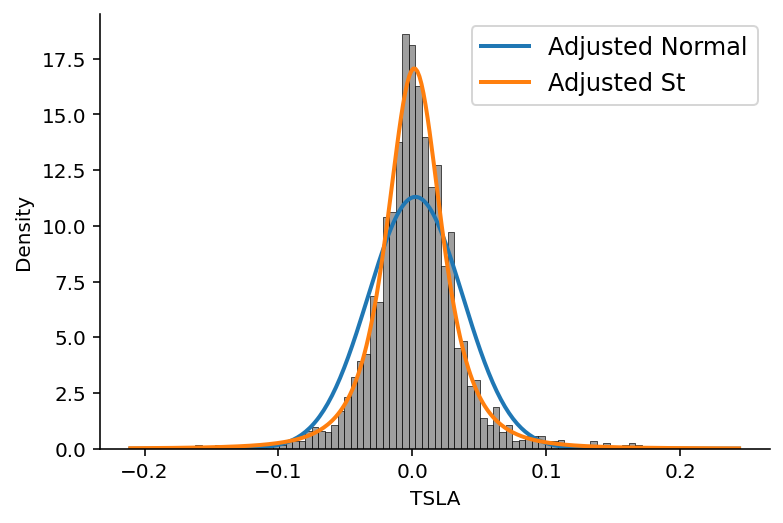

In [11]:
xrange = np.linspace(stock_ret.min(), stock_ret.max(), 300)
sns.histplot(stock_ret, kde=False, stat="density", color="tab:gray");
plt.plot(xrange, N_stock.pdf(xrange), label="Adjusted Normal", c="tab:blue", linewidth=2)
plt.plot(xrange, st.pdf(xrange), label="Adjusted St", c="tab:orange", linewidth=2)
plt.legend(fontsize=12);